In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

df = pd.read_csv('C:/Users/shawn/Desktop/CreditCard/data/creditcard.csv')


# for handling time, 


<Axes: >

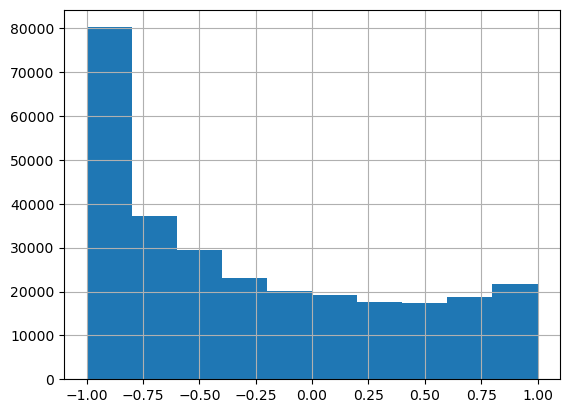

In [2]:
def encode_cyclical_feature(df: pd.DataFrame, col: str, max_val: int) -> pd.DataFrame:
    df[f"{col}_sin"] = np.sin(2 * np.pi * df[col] / max_val)
    df[f"{col}_cos"] = np.cos(2 * np.pi * df[col] / max_val)
    return df
df = encode_cyclical_feature(df, 'Time', 24*60*60) # 24 * 60 * 60 is the number of seconds in a day

df['Time_sin'].hist()
# df['Time_cos'].hist()


In [ ]:
# Add time of day
seconds_in_day = 24 * 60 * 60
df['Time_of_Day'] = df['Time'] % seconds_in_day

In [ ]:
epsilon = 0.1
df['Amount_log'] = np.log(df['Amount'] + epsilon)
df.columns
X = df.drop(columns = ['Amount', 'Time', 'Time_of_Day', 'Class']).values
#also dropped the time column I created
y = df['Class'].values

In [ ]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import average_precision_score, make_scorer

# Assuming X, y are already defined

# Split the data with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Base model
model = LogisticRegression(max_iter=10**4, solver='saga')  # saga supports l1 and l2

# Grid of hyperparameters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Smaller C = stronger regularization
    'class_weight': [None, 'balanced', {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 100}],
    'penalty': ['l1', 'l2']
}

# Custom scorer for AUC-PR (average precision)
auc_pr_scorer = make_scorer(average_precision_score, needs_proba=True)

# Override the _fit_and_score method of GridSearchCV to print timing per fit
from sklearn.model_selection._validation import _fit_and_score as original_fit_and_score
import functools

def timed_fit_and_score(*args, **kwargs):
    start = time.time()
    result = original_fit_and_score(*args, **kwargs)
    elapsed = time.time() - start
    params = kwargs.get('parameters', {})
    print(f"Fitting params {params} took {elapsed:.2f} seconds")
    return result

# Patch GridSearchCV
GridSearchCV._fit_and_score = staticmethod(timed_fit_and_score)

# Setup GridSearchCV with AUC-PR scorer
grid_search = GridSearchCV(
    model,
    param_grid,
    scoring=auc_pr_scorer,
    cv=5,
    refit=True,
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Print best params and best AUC-PR score from cross-validation
print("Best parameters:", grid_search.best_params_)
print(f"Best cross-validated AUC-PR: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_test_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
test_auc_pr = average_precision_score(y_test, y_test_proba)
print(f"Test set AUC-PR: {test_auc_pr:.4f}")


c:\Users\shawn\miniconda3\envs\MachineLearning\lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [ ]:
# Find average amount transaction for fraud and non-fraud
# Pipeline: log transform the amount class, interaction features, estimator
